In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
from matplotlib import pyplot as plt
%matplotlib inline

Взять с прошлого домашнего задания ряд (в двух вариантах - стационарный и нет) и приблизить оба эти варианта моделями из класса MA. Оценить качество и прислать соображения почему была выбрана та или иная модель

## Нестационарный ряд

In [2]:
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")["Count"]

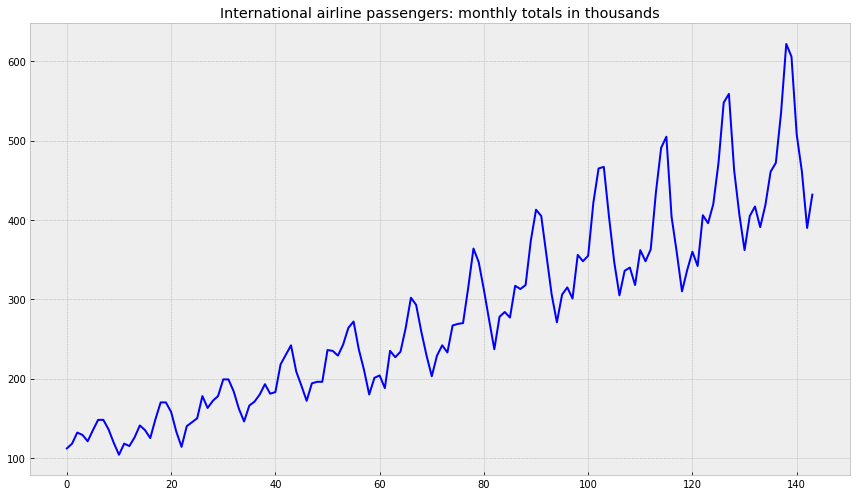

In [3]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 7))
    plt.plot(airlines_passengers, color='blue')
    plt.title('International airline passengers: monthly totals in thousands')
    plt.tight_layout()

Приблизим его с помощью метода Хольта-Винтерса, т.к. в данном ряде прослеживается сезонность.

In [9]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i])/season_len
    return sum / season_len

In [10]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [11]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [12]:
def plot_tema(alpha, beta, gamma, ser=airlines_passengers, ser_to_plot=airlines_passengers, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

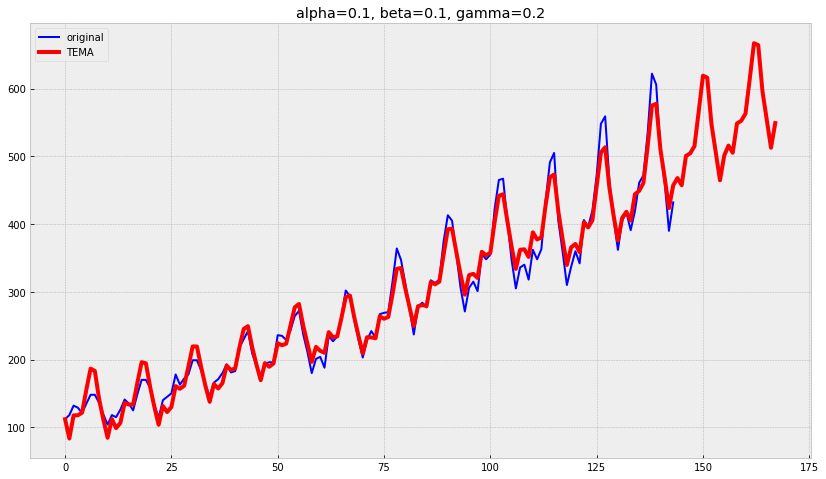

In [13]:
plot_tema(0.1, 0.1, 0.2)

Подберем параметры, используя кросс-валидацию

In [14]:
def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [15]:
train, val = airlines_passengers[:110], airlines_passengers[110:]

In [16]:
opt = minimize(mse_cross_val, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [17]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

      fun: 291.5176164517718
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.04023457e-03, -2.12594387e-03, -1.87561858e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 20
   status: 0
  success: True
        x: array([0.22537763, 0.07393616, 1.        ])


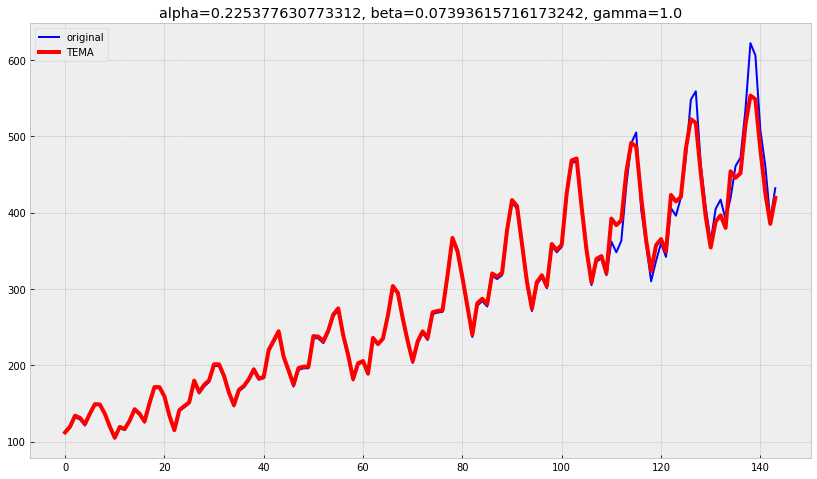

In [18]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser=train, ser_to_plot=airlines_passengers, n_preds=len(val))

Как видно, метод Хольта-Винтерса хорошо приблизил наш ряд с ошибкой MSE в 291. Предсказанный ряд учитывает сезонность и тренд.

## Стационарный ряд

In [19]:
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")["Count"]

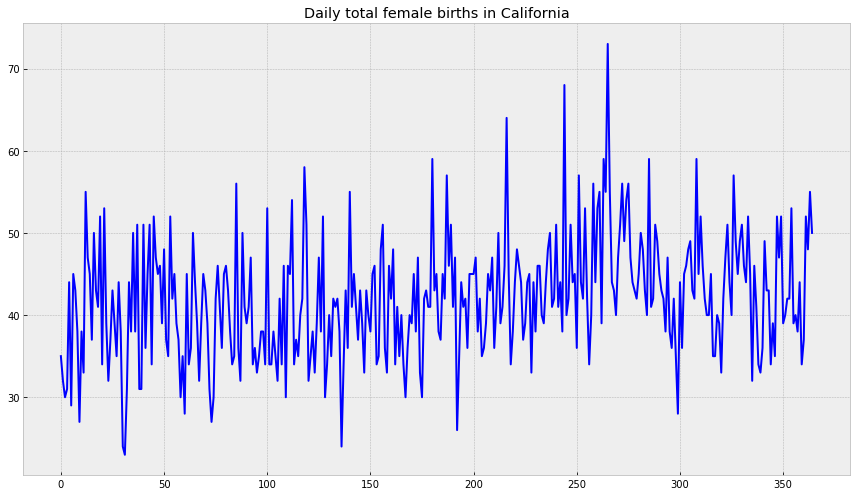

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize=(12, 7))
    plt.plot(female_births, color='blue')
    plt.title('Daily total female births in California')
    plt.tight_layout()

Т.к. в данном ряде нет сезонности, попробуем использовать метод двойного экспоненциального сглаживания.

In [21]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [22]:
def plot_dema(alpha, beta):
    dema = double_ema(female_births, alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(female_births, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

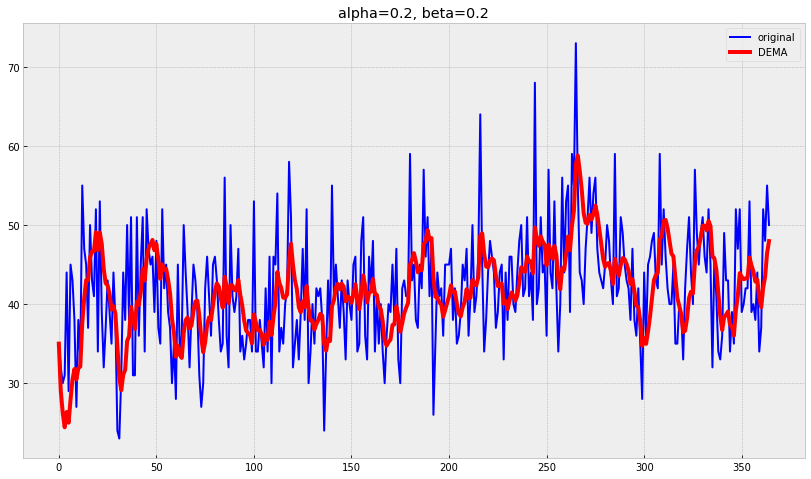

In [23]:
plot_dema(0.2, 0.2)

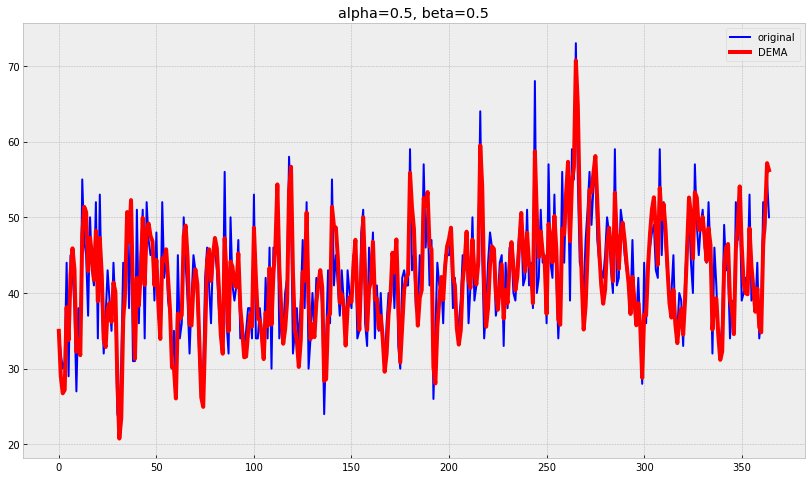

In [24]:
plot_dema(0.5, 0.5)

Подберем оптимальные параметры, используя кросс-валидацию

In [25]:
def mse_cross_val(X):
    alpha, beta = X
    split = TimeSeriesSplit(n_splits=3) 
    errors = []
    
    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]

        result = double_ema(train_split_ts, alpha, beta)
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)

    return np.mean(np.array(errors))

In [26]:
train, val = female_births[:250], female_births[250:]

In [27]:
opt = minimize(mse_cross_val, x0=[0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [28]:
alpha_opt, beta_opt = opt.x
print(opt)

      fun: 56.001046540349044
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.09423581e-04, 4.90274488e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 14
   status: 0
  success: True
        x: array([0.24076581, 0.09091163])


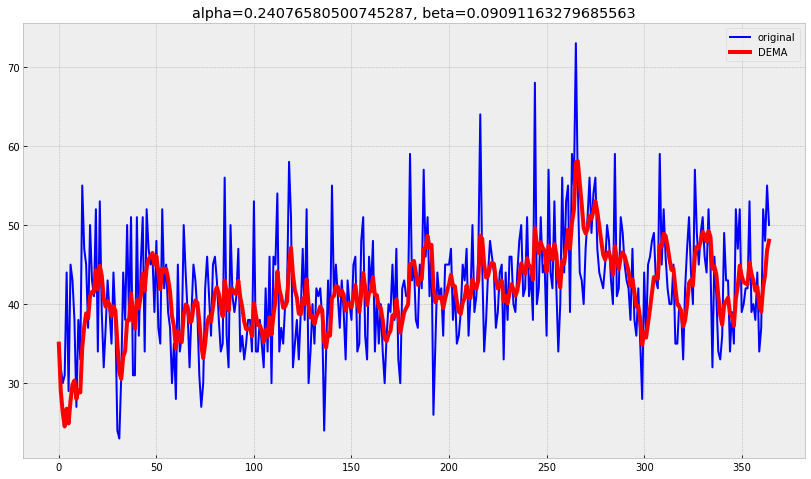

In [29]:
plot_dema(alpha_opt, beta_opt)

В общем модели примерно удалось уловить поведение ряда + ошибка MSE всего 56, но из графика видно, что модель не учла дисперсию, резкие изменения и выбросы, получилась слишком сглаженной.